# Business Problem

- Which product categories has lower reviews / maybe inferior products? (ie. electronics, iPad)
- Which product have higher reviews / maybe superior products?
    
Business solutions:
- **Which products should be kept, dropped from Amazon's product roster (which ones are junk?)**
- **Also: can we associate positive and negative words/sentiments for each product in Amazon's Catalog**
- By using Sentiment analysis, can we predict scores for reviews based on certain words


# Quick Look at the Raw Data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") # Plotting style

np.random.seed(7) # seeding random number generator

csv = "C:/Users/thakr/Downloads/archive (2)/1429_1.csv"
df = pd.read_csv(csv)
df.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [47]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

- We can potentially refine sentiment analysis with the reviews.text column, with the actual rating of reviews.doRecommend column (boolean)
- We can also label each review based on each sentiment
    - title can contain positive/negative information about review

In [5]:
data = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [7]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B002Y27P3M',
       'B01AHB9CYG', 'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2',
       'B0083Q04TA', 'B018Y229OU', 'B00REQKWGA', 'B00IOYAM4I',
       'B018T075DC', nan, 'B00DU15MU4', 'B018Y225IA', 'B005PB2T2Q',
       'B018Y23MNM', 'B00OQVZDJM', 'B00IOY8XWQ', 'B00LO29KXQ',
       'B00QJDU3KY', 'B018Y22C2Y', 'B01BFIBRIE', 'B01J4ORNHU',
       'B018SZT3BK', 'B00UH4D8G2', 'B018Y22BI4', 'B00TSUGXKE',
       'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K', 'B00X4WHP5E', 'B00QFQRELG',
       'B00LW9XOJM', 'B00QL1ZN3G', 'B0189XYY0Q', 'B01BH83OOM',
       'B00BFJAHF8', 'B00U3FPN4U', 'B002Y27P6Y', 'B006GWO5NE',
       'B006GWO5WK'], dtype=object)

In [8]:
asins_unique = len(data["asins"].unique())
print("Number of Unique ASINs: " + str(asins_unique))

Number of Unique ASINs: 42


**Visualizing the distributions of numerical variables:**

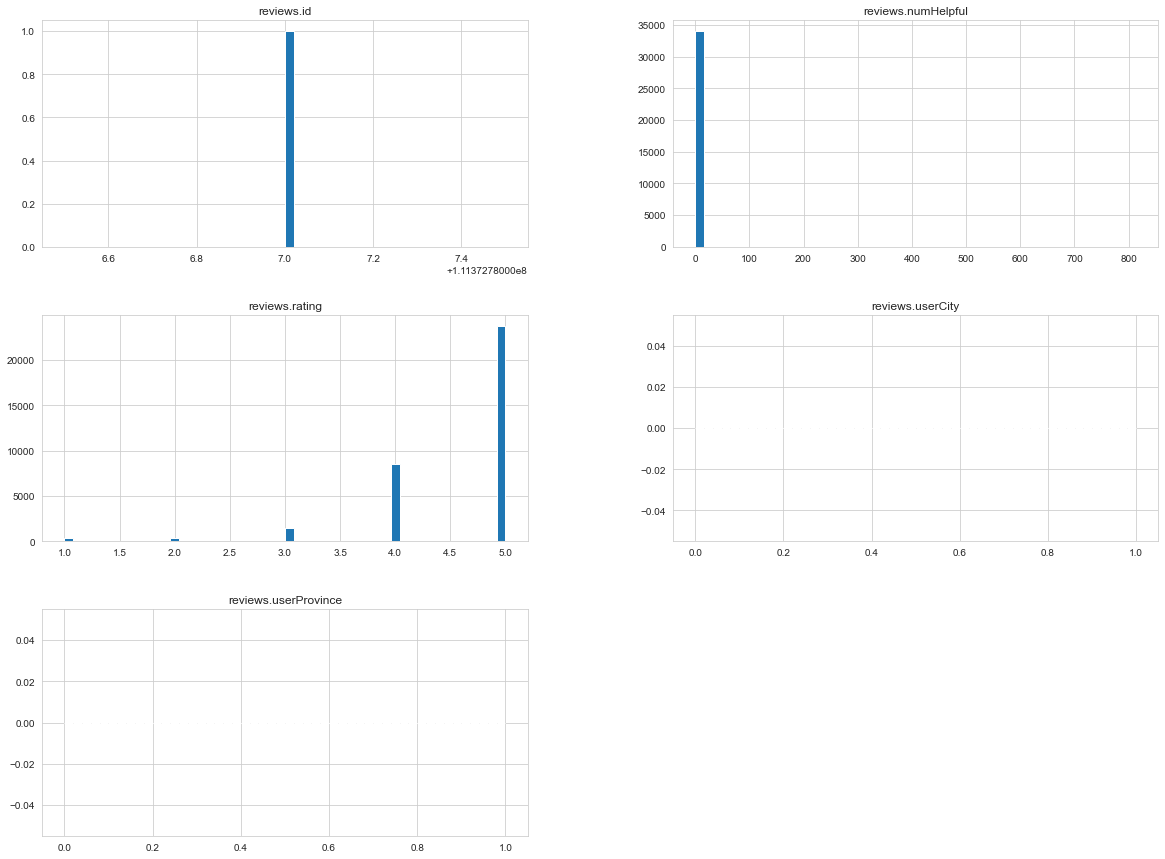

In [9]:
data.hist(bins=50, figsize=(20,15)) # builds histogram and set the number of bins and fig size (width, height)
plt.show()

# Split into Train/Test

- Before we explore the dataset we're going to split it into training set and test sets
- Our goal is to eventually train a sentiment analysis classifier
- Since the majority of reviews are positive (5 stars), we will need to do a stratified split on the reviews score to ensure that we don't train the classifier on imbalanced data
- To use sklearn's `Stratified ShuffleSplit` class, we're going to remove all samples that have NAN in review score, then covert all review scores to `integer` datatype

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["reviews.rating"]) # removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

Before 34660
After 34627


In [11]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["reviews.rating"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

In [48]:
dataAfter

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34655,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-09-18T00:00:00Z,NaN,2015-08-29T00:00:00Z,...,NaN,NaN,NaN,3,http://www.amazon.com/Amazon-PowerFast-Adapter...,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...,NaN,NaN,Kris
34656,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-11-21T00:00:00Z,NaN,2015-09-02T00:00:00Z,...,NaN,NaN,NaN,1,http://www.amazon.com/Amazon-PowerFast-Adapter...,Amazon should include this charger with the Ki...,Should be included,NaN,NaN,Jonathan Stewart
34657,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-10-19T00:00:00Z,NaN,2015-09-04T00:00:00Z,...,NaN,NaN,NaN,1,http://www.amazon.com/Amazon-PowerFast-Adapter...,Love my Kindle Fire but I am really disappoint...,Disappointing Charger,NaN,NaN,J Lawson
34658,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012

In [12]:
len(strat_train)

27701

In [13]:
strat_train["reviews.rating"].value_counts()/len(strat_train) # value_count() counts all the values based on column

5.0    0.685174
4.0    0.247031
3.0    0.043500
2.0    0.011696
1.0    0.011588
Name: reviews.rating, dtype: float64

In [14]:
len(strat_test)

6926

In [15]:
strat_test["reviews.rating"].value_counts()/len(strat_test)

5.0    0.689864
4.0    0.244730
3.0    0.042160
1.0    0.011406
2.0    0.011118
Name: reviews.rating, dtype: float64

# Data Exploration (Training Set)

In [16]:
reviews = strat_train.copy()
reviews.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
4349,AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B018Y229OU,Amazon,"Fire Tablets,Tablets,Computers & Tablets,All T...",firetablet7displaywifi8gbincludesspecialoffers...,Amazon,2015-11-28T00:00:00.000Z,2017-05-21T04:06:08Z,"2017-04-30T00:26:00.000Z,2017-06-07T08:10:00.000Z",...,True,NaN,5.0,5.0,http://reviews.bestbuy.com/3545/5025800/review...,we bought this for my 11 year old daughter and...,great for all ages,NaN,NaN,Mark
30776,AV1YE_muvKc47QAVgpwE,NaN,B00U3FPN4U,Amazon Fire Tv,"Back To College,College Electronics,College Tv...","848719057492,amazonfiretv/51454342,amazonfiret...",Amazon,2017-01-06T00:00:00.000Z,2017-09-20T05:35:55Z,"2017-08-25T22:21:42.763Z,2017-08-19T09:26:46.1...",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/4370400/review...,"I have the Roku 4, and new Apple TV, this stre...",Great streaming box,NaN,NaN,Techno


## names / ASINs

In [17]:
len(reviews["name"].unique()), len(reviews["asins"].unique())

(47, 35)

In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.sourceUR

In [19]:
reviews.groupby("asins")["name"].unique()

asins
B005PB2T0S               [Amazon Kindle Lighted Leather Cover,,,\r\nAma...
B005PB2T2Q               [Fire Kids Edition Tablet, 7 Display, Wi-Fi, 1...
B00IOY8XWQ               [Kindle Paperwhite,,,\r\nKindle Paperwhite,,,,...
B00IOYAM4I               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00L9EPT8O,B01E6AO69U    [Echo (White),,,\r\nEcho (White),,,, Amazon Fi...
B00LO29KXQ               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00LW9XOJM                                                           [nan]
B00OQVZDJM               [Amazon Kindle Paperwhite - eBook reader - 4 G...
B00QFQRELG                                                           [nan]
B00QJDU3KY               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00QL1ZN3G                                                           [nan]
B00REQKWGA               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00TSUGXKE                            [Echo (White),,,\r\nEcho (White),,,]
B00U3FPN4U         

<u>Note</u>: there are actually 34 ASINs with one of the product having 2 ASINs

In [20]:
# Lets see all the different names for this product that have 2 ASINs
different_names = reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].unique()
for name in different_names:
    print(name)

Echo (White),,,
Echo (White),,,
Amazon Fire Tv,,,
Amazon Fire Tv,,,
nan
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red

In [21]:
reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].value_counts()

Echo (White),,,\r\nEcho (White),,,                                                                                                                                                                                  2318
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                                                                                                              2029
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,\r\nAmazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,                                                                           259
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,\r\nAmazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,                                                           106
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 9W PowerFast Offici

**Confirmed our hypothesis that each ASIN can have multiple names. Therefore we should only really concern ourselves with which ASINs do well, not the product names.**

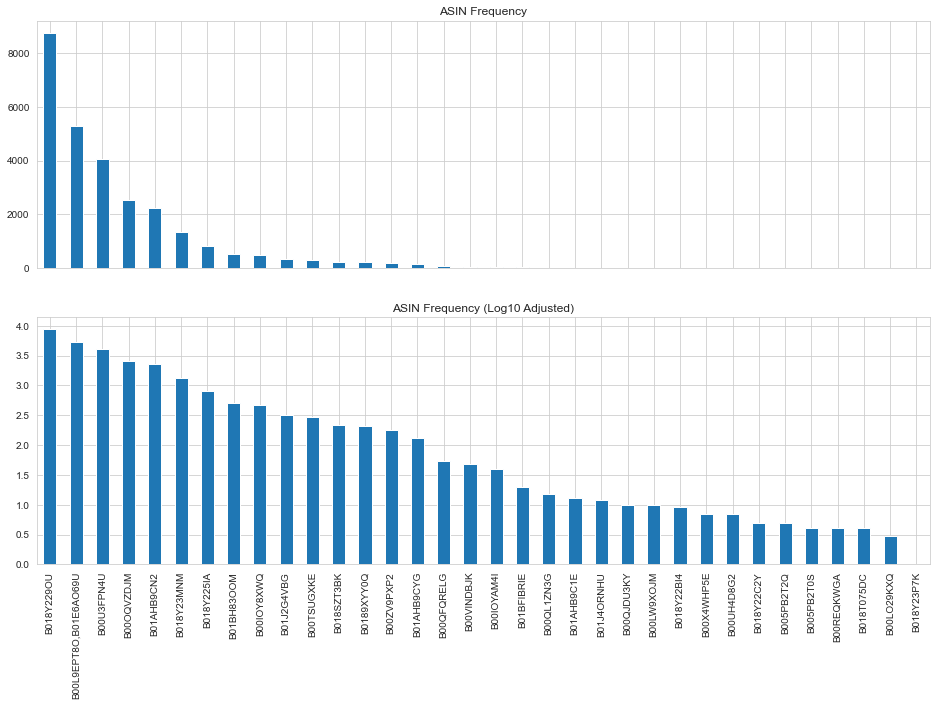

In [22]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")
np.log10(reviews["asins"].value_counts()).plot(kind="bar", ax=ax2, title="ASIN Frequency (Log10 Adjusted)") 
plt.show()

- Based on the bar graph for ASINs, we see that certain products have significantly more reviews than other products, which may indicate a higher sale in those specific products
- We also see that the ASINs have a "right tailed" distribution which can also suggest that certain products have higher sales which can correlate to the higher ASINs frequencies in the reviews
- We also took the log of the ASINs to normalize the data, in order display an in-depth picture of each ASINs, and we see that the distribution still follows a "right tailed" distribution

**This answers the first question that certain ASINs (products) have better sales, while other ASINs have lower sale, and in turn dictates which products should be kept or dropped.**

In [23]:
# Entire training dataset average rating
reviews["reviews.rating"].mean()

4.5841072525566435

## reviews.rating / ASINs

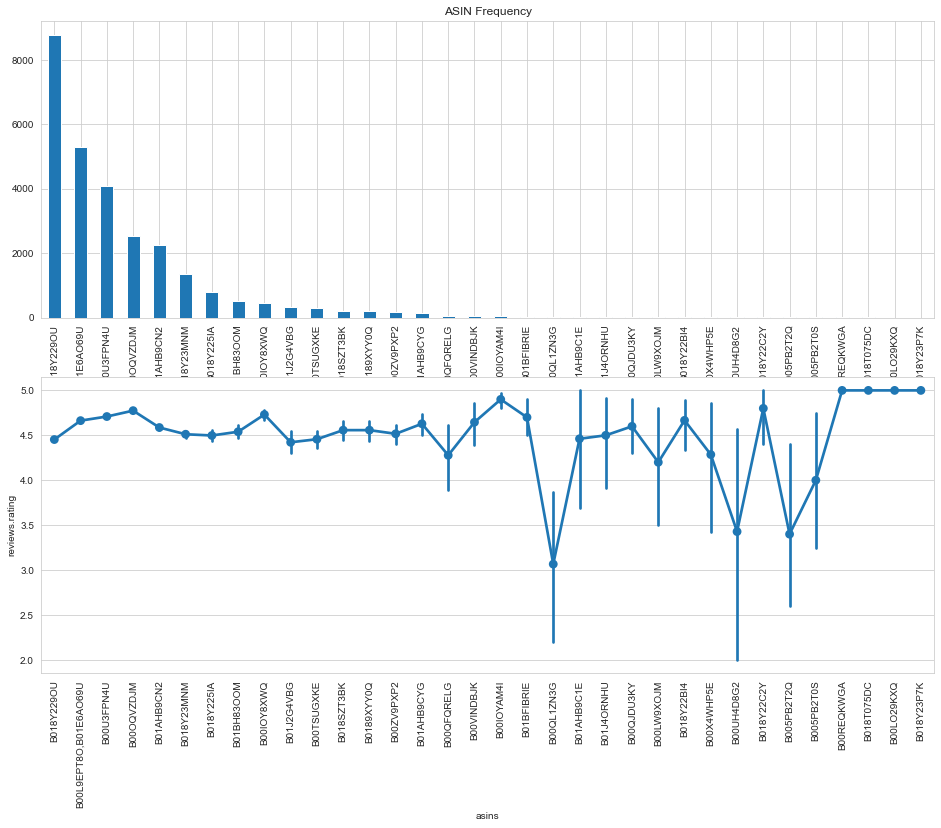

In [24]:
asins_count_ix = reviews["asins"].value_counts().index
plt.subplots(2,1,figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

**point-plot graph automatically takes the average of the review.rating data.**

## reviews.doRecommend / ASINs

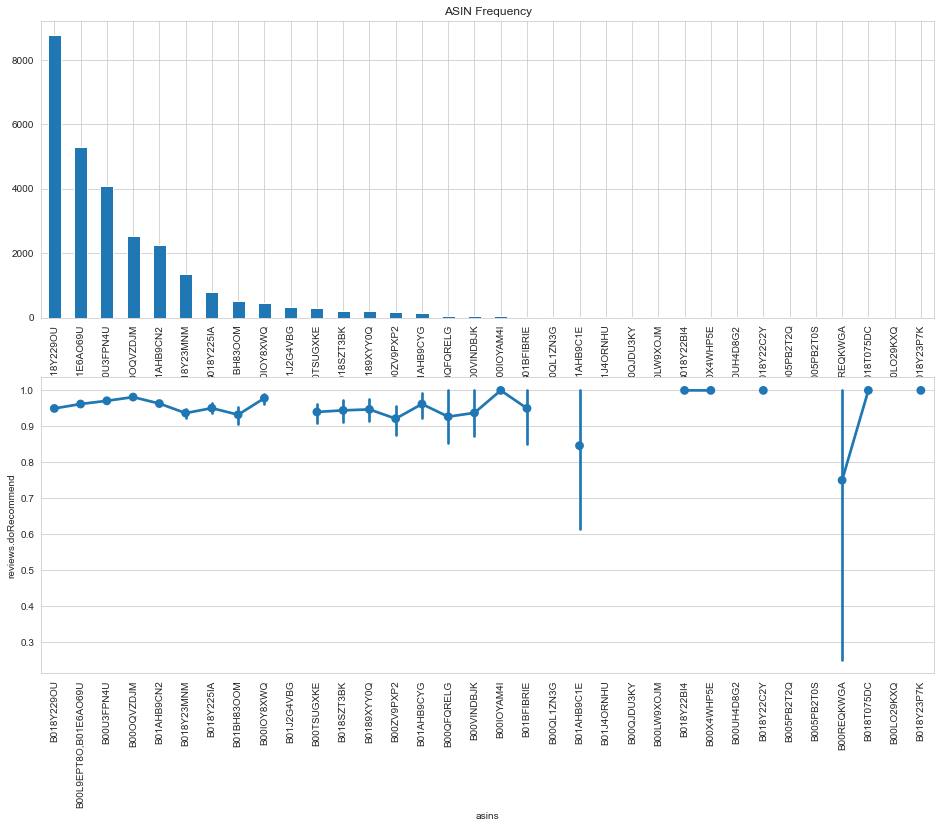

In [25]:
plt.subplots (2,1,figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.doRecommend", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

# Correlations

In [26]:
corr_matrix = reviews.corr()
corr_matrix
# Here we can analyze reviews.ratings with asins

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
reviews.id,NaN,NaN,NaN,NaN,NaN
reviews.numHelpful,NaN,1.00000,-0.04372,NaN,NaN
reviews.rating,NaN,-0.04372,1.00000,NaN,NaN
reviews.userCity,NaN,NaN,NaN,NaN,NaN
reviews.userProvince,NaN,NaN,NaN,NaN,NaN


In [27]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.sourceUR

In [28]:
counts = reviews["asins"].value_counts().to_frame()
counts.head()

,asins
B018Y229OU,8772
"B00L9EPT8O,B01E6AO69U",5304
B00U3FPN4U,4076
B00OQVZDJM,2525
B01AHB9CN2,2241


In [29]:
avg_rating = reviews.groupby("asins")["reviews.rating"].mean().to_frame()
avg_rating.head()

,reviews.rating
asins,
B005PB2T0S,4.000000
B005PB2T2Q,3.400000
B00IOY8XWQ,4.731183
B00IOYAM4I,4.900000
"B00L9EPT8O,B01E6AO69U",4.663462


In [30]:
table = counts.join(avg_rating)
table.head(30)

,asins,reviews.rating
B018Y229OU,8772,4.453032
"B00L9EPT8O,B01E6AO69U",5304,4.663462
B00U3FPN4U,4076,4.709028
B00OQVZDJM,2525,4.774653
B01AHB9CN2,2241,4.586792
B018Y23MNM,1346,4.511887
B018Y225IA,811,4.498150
B01BH83OOM,504,4.539683
B00IOY8XWQ,465,4.731183
B01J2G4VBG,322,4.422360


,asins,reviews.rating
asins,1.000000,0.099791
reviews.rating,0.099791,1.000000


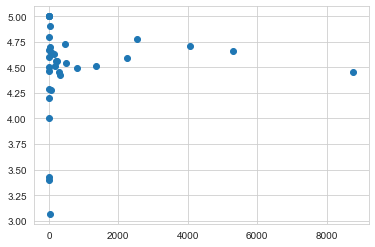

In [31]:
plt.scatter("asins", "reviews.rating", data=table)
table.corr()

From our analysis in data exploration above between ASINs and reviews.rating, we discovered that there are many ASINs with low occurrence that have high variances, as a result we concluded that theses low occurrence ASINs are not significant in our analysis given the low sample size.
<br>
<br>
Similarly in our correlation analysis between ASINs and reviews.rating, we see that there is almost no correlation which is consistent with our findings.

# Sentiment Analysis

## Set Target Variable (Sentiments)

Segregate ratings from 1-5 into positive, neutral, and negative.

In [32]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
strat_train["Sentiment"] = strat_train["reviews.rating"].apply(sentiments)
strat_test["Sentiment"] = strat_test["reviews.rating"].apply(sentiments)
strat_train["Sentiment"][:20]

4349     Positive
30776    Positive
28775     Neutral
1136     Positive
17803    Positive
7336     Positive
32638    Positive
13995    Positive
6728     Negative
22009    Positive
11047    Positive
22754    Positive
5578     Positive
11673    Positive
19168    Positive
14903    Positive
30843    Positive
5440     Positive
28940    Positive
31258    Positive
Name: Sentiment, dtype: object

In [35]:
# Prepare data
X_train = strat_train["reviews.text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["reviews.text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(len(X_train), len(X_test))

27701 6926


27,701 training samples and 6926 testing samples.

## Extract Features

In [36]:
# Replace "nan" with space
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(27701, 12526)

Here we have 27,701 training samples and 12,526 distinct words in our training sample.


Also, with longer documents, we typically see higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use **TfidfTransformer** to reduce this redundancy:
- Term Frequencies (**Tf**) divides number of occurrences for each word by total number of words
- Term Frequencies times Inverse Document Frequency (**Tfidf**) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(27701, 12526)

## Building a Pipeline from the Extracted Features

We will use **Multinominal Naive Bayes** as our Classifier
- Multinominal Niave Bayes is most suitable for word counts where data are typically represented as **word vector counts** (number of times outcome number X[i,j] is observed over the n trials), while also ignoring non-occurrences of a feature i
- Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed conditioned independent to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, X_train_targetSentiment)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])

## Test Model

In [39]:
import numpy as np
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == X_test_targetSentiment)

0.9344498989315623

Here we see that our Multinominal Naive Bayes Classifier has a 93.45% accuracy level based on the features. 
<br>
<br>
Next we will conduct the following:
- Test other models
- Fine tune the best models to avoid over-fitting

## Testing Other Models

**Logistic Regression Classifier**

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

import numpy as np
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.9392145538550389

**Support Vector Machine Classifier**

In [58]:
from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)

0.9393589373375686

In [57]:
clf_linearSVC_pipe.score(X_test_targetSentiment , predictedLinearSVC)

0.9789200115506786

**Decision Tree Classifier**

In [42]:
from sklearn.tree import DecisionTreeClassifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())])
clf_decisionTree_pipe.fit(X_train, X_train_targetSentiment)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == X_test_targetSentiment)

0.9016748483973434

**Random Forest Classifier**

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randomForest", RandomForestClassifier())])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == X_test_targetSentiment)

0.9350274328616807